# Fair VAE
This framework mainly follows scVI with an extra MMD penalty across batches based on Fair VAE paper.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import scanpy as sc
import anndata
from torch.distributions import Normal, kl_divergence as kl
import numpy as np
import matplotlib.pyplot as plt

In [4]:
raw_adata = sc.read("../data/merging_data_wu_liu.h5ad")

# Dataset

In [5]:
class AnnDataset(torch.utils.data.Dataset):
    def __init__(self, X_ann):
        # TODO
        # 1. Initialize file paths or a list of file names.
        self.X = X_ann.obsm['X']
        self.local_mean = X_ann.obs['local_mean']
        self.local_var = X_ann.obs['local_var']
        self.batch = X_ann.obs['Batch']
        self.one_hot = X_ann.obsm['one_hot']
#        self.batch_index = X_ann.obs['batch_index']
#        self.fake_labels = X_ann.obs['fake_labels']
    def __getitem__(self, index):
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        sample_x = self.X[index]
        sample_local_mean = self.local_mean[index]
        sample_local_var = self.local_var[index]
        sample_batch = self.batch[index]
        sample_one_hot = self.one_hot[index]
#        sample_batch_index = self.batch_index[index]
#        sample_fake_labels = self.fake_labels[index]

        sample = {'x': sample_x, 'local_mean':sample_local_mean,'local_var':sample_local_var,
                 'batch':sample_batch,"one_hot":sample_one_hot}
#                 'batch_index':sample_batch_index,'fake_labels':sample_fake_labels}
        return sample

    def __len__(self):
        # the total size of your dataset.
        return len(self.X)



In [6]:
local_mean_1 = np.log(raw_adata.obsm['X'][raw_adata.obs['Batch'] == 1.0].sum(axis=1)).mean()
local_mean_0 = np.log(raw_adata.obsm['X'][raw_adata.obs['Batch'] == 0.0].sum(axis=1)).mean()


local_var_1 = np.log(raw_adata.obsm['X'][raw_adata.obs['Batch'] == 1.0].sum(axis=1)).var()
local_var_0 = np.log(raw_adata.obsm['X'][raw_adata.obs['Batch'] == 0.0].sum(axis=1)).var()

In [7]:
size = raw_adata.obsm['one_hot'].sum(axis=0).astype("int")

In [8]:
raw_adata.obs['local_mean'] = np.concatenate((local_mean_1 * np.ones(size[0]), local_mean_0 * np.ones(size[1])))

raw_adata.obs['local_var'] = np.concatenate((local_var_1 * np.ones(size[0]), local_var_0 * np.ones(size[1])))

#raw_adata.obs['clusters'] = raw_adata.obs['Group']

# Loss

In [9]:
def log_zinb_positive(x, mu, theta, pi, eps=1e-8):


    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(
            1, theta.size(0)
        )  # In this case, we reshape theta for broadcasting

    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)

    res = mul_case_zero + mul_case_non_zero

    return res

# Model

In [10]:
def reparameterize_gaussian(mu, var):
    return Normal(mu, var.sqrt()).rsample()

class Encoder(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(n_in, n_hidden),
                                     nn.BatchNorm1d(n_hidden, momentum=0.01, eps=0.001),
                                     nn.ReLU(),
                                     nn.Linear(n_hidden, n_hidden),
                                     nn.BatchNorm1d(n_hidden, momentum=0.01, eps=0.001),
                                     nn.ReLU())
        self.mean_encoder = nn.Linear(n_hidden, n_out)
        self.var_encoder = nn.Linear(n_hidden, n_out)
        
    def forward(self, x: torch.Tensor):
        
        q = self.encoder(x)
        
        q_m = self.mean_encoder(q)
        q_v = torch.exp(self.var_encoder(q)) + 1e-4
        latent = reparameterize_gaussian(q_m, q_v)
        
        return q_m, q_v, latent
    
class Decoder(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()

        self.px_decoder = nn.Sequential(nn.Linear(n_in+2, n_hidden),
                                       nn.BatchNorm1d(n_hidden, momentum=0.01, eps=0.001),
                                       nn.ReLU(),
                                     nn.Linear(n_hidden, n_hidden),
                                     nn.BatchNorm1d(n_hidden, momentum=0.01, eps=0.001),
                                     nn.ReLU())
        
        # mean gamma
        self.px_scale_decoder = nn.Sequential(
            nn.Linear(n_hidden, n_out), nn.Softmax(dim=-1)
        )        

        # dropout
        self.px_dropout_decoder = nn.Linear(n_hidden, n_out)

        # dispersion: here we only deal with gene-cell dispersion case
        self.px_r_decoder = nn.Linear(n_hidden, n_out)


        
    def forward(self, z: torch.Tensor, library: torch.Tensor, one_hot: torch.Tensor):
        
        px = self.px_decoder(torch.cat((z,one_hot),dim=1))
        px_scale = self.px_scale_decoder(px)
        px_rate = torch.exp(library) * px_scale  
        # torch.clamp( , max=12)

        px_dropout = self.px_dropout_decoder(px)
        
        px_r = self.px_r_decoder(px) 

        return px_scale, px_r, px_rate, px_dropout

In [11]:
class VAE(nn.Module):
    def __init__(self,n_input, n_hidden = 128, n_latent_z = 32, n_latent_pi = 10):
        super().__init__()
        self.z_encoder = Encoder(n_input, n_hidden, n_latent_z)
   #     self.pi_encoder = Encoder(n_input,n_hidden, n_latent_pi)
        self.l_encoder = Encoder(n_input, n_hidden, 1)
        
        self.decoder_z = Decoder(n_latent_z, n_hidden, n_input)
        
    #    self.decoder_pi = Decoder(n_latent_pi, n_hidden, n_input)
        
        self.px_r = torch.nn.Parameter(torch.randn(n_input))

    def forward(self, x: torch.Tensor, one_hot):
        x_ = x
        x_ = torch.log(1 + x_)
        
        qz_m, qz_v, z = self.z_encoder(x_)
        ql_m, ql_v, library = self.l_encoder(x_)
    #    q_pi_m, q_pi_v, q_pi = self.pi_encoder(x_)
        
        px_scale, _ , px_rate, px_dropout = self.decoder_z(z, library,one_hot)
        
        px_r = self.px_r
        
        px_r = torch.exp(px_r)
        
        return px_scale, px_rate, px_r, px_dropout, qz_m, qz_v, ql_m, ql_v
    
    def get_latent(self, x:torch.Tensor):
        with torch.no_grad():
            x_ = x
            x_ = torch.log(1 + x_)
        
            qz_m, qz_v, z = self.z_encoder(x_)
            
        return qz_m
    def get_library(self, x):
        x_ = x
        x_ = torch.log(1 + x_)
        
        with torch.no_grad():
            
            ql_m, ql_v, library = self.l_encoder(x_)
        return library

    def regenerate(self,z,library, one_hot):
        with torch.no_grad():
            px_scale, _ , px_rate, px_dropout = self.decoder_z(z, library,one_hot)
        return px_rate

In [12]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [13]:
def train(model, train_loader,optimizer, val_loader = None, start_epoch = 0,num_epochs=30, seed=1,
        n_epochs_kl_warmup = 400,
          save_path = "train_with_tsne/"):

    for epoch in range(start_epoch,num_epochs):
        model.train()
        print(optimizer.param_groups[0]['lr'])
        kl_weight = min(1, epoch/n_epochs_kl_warmup)

        for i, sample in enumerate(train_loader):
            x = sample['x']
            local_l_mean = sample['local_mean']
            local_l_var = sample['local_var']
            batch = sample['batch']
            one_hot = sample['one_hot']
            one_hot = one_hot.float()
            px_scale, px_rate, px_r, px_dropout, qz_m, qz_v, ql_m, ql_v = model(x, one_hot)

            reconst_loss = -log_zinb_positive(x,px_rate,px_r,px_dropout).sum(dim=-1)
            
            mean = torch.zeros_like(qz_m)
            scale = torch.ones_like(qz_v)

            kl_divergence_z = kl(Normal(qz_m, torch.sqrt(qz_v)), Normal(mean, scale)).sum(
                dim=1)
            
            kl_divergence_l = kl(Normal(ql_m, torch.sqrt(ql_v)),Normal(local_l_mean, torch.sqrt(local_l_var))).sum(dim=1)
            
            reconst_loss = reconst_loss.mean()
            kl_divergence_z = kl_divergence_z.mean()
            kl_divergence_l = kl_divergence_l.mean()
            
            qz_m_1 = qz_m[batch==1.]
            qz_m_0 = qz_m[batch==0.]
            
            mmd = compute_mmd(qz_m_0,qz_m_1)
            
            n = x.shape[0]
            mmd = n * mmd
            
            loss = reconst_loss + kl_weight * (kl_divergence_z + kl_divergence_l + mmd)
            loss = loss.mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
     #       scheduler.step(loss)


            if i % 5 == 0:
                print("Epoch[{}/{}], Step [{}/{}],  Loss: {:.4f}, Rec Loss: {:.4f}, KL Z:{:.4f}, KL L:{:.4f}, MMD:{:.4f}".format(
                                        epoch, num_epochs, i, len(train_loader), loss.item(), reconst_loss.item(),
                kl_divergence_z.item(), kl_divergence_l.item(), mmd.item()))




In [14]:
ann_dataset = AnnDataset(raw_adata)
train_loader = torch.utils.data.DataLoader(dataset=ann_dataset,
                                           batch_size=512, 
                                           shuffle=True,drop_last = True)

In [15]:
vae = VAE(n_input = raw_adata.obsm['X'].shape[1],n_latent_z=32,n_hidden=128)
learning_rate=1e-3
weight_decay = 1e-6
eps = 0.01
params = vae.parameters()
optimizer = torch.optim.Adam(
            params, lr=learning_rate, eps=eps, weight_decay= weight_decay
        )   

In [16]:
epoch = -1

In [17]:
train(vae,train_loader,optimizer, num_epochs=epoch + 100, start_epoch = epoch + 1, n_epochs_kl_warmup=50)

0.001
Epoch[0/99], Step [0/25],  Loss: 117729.0938, Rec Loss: 117729.0938, KL Z:4.2963, KL L:108265.5156, MMD:2.9213
Epoch[0/99], Step [5/25],  Loss: 89670.9062, Rec Loss: 89670.9062, KL Z:4.7983, KL L:110978.5000, MMD:15.4073
Epoch[0/99], Step [10/25],  Loss: 83626.0625, Rec Loss: 83626.0625, KL Z:7.3400, KL L:106195.1250, MMD:24.4527
Epoch[0/99], Step [15/25],  Loss: 72564.1953, Rec Loss: 72564.1953, KL Z:8.4532, KL L:108557.5000, MMD:33.8386
Epoch[0/99], Step [20/25],  Loss: 69350.9688, Rec Loss: 69350.9688, KL Z:11.2191, KL L:96912.3203, MMD:21.1794
0.001
Epoch[1/99], Step [0/25],  Loss: 63493.7852, Rec Loss: 61641.0312, KL Z:15.7317, KL L:92591.3438, MMD:30.5349
Epoch[1/99], Step [5/25],  Loss: 57879.5000, Rec Loss: 56160.6328, KL Z:19.6124, KL L:85897.8594, MMD:25.9531
Epoch[1/99], Step [10/25],  Loss: 53521.8594, Rec Loss: 51891.8242, KL Z:23.1468, KL L:81447.3359, MMD:31.2084
Epoch[1/99], Step [15/25],  Loss: 50455.2930, Rec Loss: 48941.0742, KL Z:26.3510, KL L:75659.4688, MMD:

0.001
Epoch[15/99], Step [0/25],  Loss: 8755.2617, Rec Loss: 8597.3066, KL Z:43.1541, KL L:474.7710, MMD:8.5914
Epoch[15/99], Step [5/25],  Loss: 8678.3594, Rec Loss: 8480.4092, KL Z:43.7956, KL L:603.0713, MMD:12.9669
Epoch[15/99], Step [10/25],  Loss: 8693.5605, Rec Loss: 8444.8926, KL Z:43.7394, KL L:770.5400, MMD:14.6152
Epoch[15/99], Step [15/25],  Loss: 8570.8389, Rec Loss: 8415.4502, KL Z:43.8544, KL L:458.5312, MMD:15.5756
Epoch[15/99], Step [20/25],  Loss: 8416.3291, Rec Loss: 8270.7812, KL Z:43.1041, KL L:430.9189, MMD:11.1367
0.001
Epoch[16/99], Step [0/25],  Loss: 8748.7002, Rec Loss: 8583.8828, KL Z:43.2540, KL L:463.9662, MMD:7.8356
Epoch[16/99], Step [5/25],  Loss: 8399.9502, Rec Loss: 8236.9453, KL Z:42.6799, KL L:456.9842, MMD:9.7248
Epoch[16/99], Step [10/25],  Loss: 8708.1299, Rec Loss: 8466.4238, KL Z:42.1792, KL L:701.0764, MMD:12.0754
Epoch[16/99], Step [15/25],  Loss: 8757.2451, Rec Loss: 8525.3496, KL Z:42.3828, KL L:672.9237, MMD:9.3671
Epoch[16/99], Step [20/2

Epoch[30/99], Step [5/25],  Loss: 8793.6270, Rec Loss: 8461.0146, KL Z:36.7147, KL L:513.9274, MMD:3.7116
Epoch[30/99], Step [10/25],  Loss: 8592.0693, Rec Loss: 8244.1387, KL Z:36.5656, KL L:540.0964, MMD:3.2221
Epoch[30/99], Step [15/25],  Loss: 8531.5449, Rec Loss: 8238.7441, KL Z:36.9124, KL L:448.4590, MMD:2.6295
Epoch[30/99], Step [20/25],  Loss: 8708.7598, Rec Loss: 8459.0781, KL Z:36.2172, KL L:376.4377, MMD:3.4814
0.001
Epoch[31/99], Step [0/25],  Loss: 8424.8564, Rec Loss: 8116.4863, KL Z:36.7027, KL L:457.6419, MMD:3.0259
Epoch[31/99], Step [5/25],  Loss: 8311.3740, Rec Loss: 8095.4590, KL Z:36.4643, KL L:309.5589, MMD:2.2271
Epoch[31/99], Step [10/25],  Loss: 8369.2070, Rec Loss: 8187.1631, KL Z:35.9023, KL L:255.7093, MMD:2.0074
Epoch[31/99], Step [15/25],  Loss: 8130.8721, Rec Loss: 7938.9312, KL Z:35.6168, KL L:272.1493, MMD:1.8163
Epoch[31/99], Step [20/25],  Loss: 8600.2822, Rec Loss: 8379.1992, KL Z:35.6958, KL L:318.4799, MMD:2.4093
0.001
Epoch[32/99], Step [0/25],  

Epoch[45/99], Step [15/25],  Loss: 8202.9082, Rec Loss: 7968.0864, KL Z:29.3154, KL L:230.6840, MMD:0.9137
Epoch[45/99], Step [20/25],  Loss: 8756.6328, Rec Loss: 8476.2891, KL Z:29.4290, KL L:281.1429, MMD:0.9208
0.001
Epoch[46/99], Step [0/25],  Loss: 8395.3779, Rec Loss: 8110.8589, KL Z:29.1365, KL L:279.3977, MMD:0.7261
Epoch[46/99], Step [5/25],  Loss: 8624.6270, Rec Loss: 8216.4463, KL Z:28.8003, KL L:413.7920, MMD:1.0823
Epoch[46/99], Step [10/25],  Loss: 8249.7725, Rec Loss: 8013.2412, KL Z:29.3622, KL L:227.1139, MMD:0.6232
Epoch[46/99], Step [15/25],  Loss: 8391.8740, Rec Loss: 8179.1064, KL Z:29.3065, KL L:201.0326, MMD:0.9300
Epoch[46/99], Step [20/25],  Loss: 8311.1016, Rec Loss: 8001.0195, KL Z:28.9814, KL L:306.8364, MMD:1.2282
0.001
Epoch[47/99], Step [0/25],  Loss: 8341.4541, Rec Loss: 8133.4546, KL Z:29.1369, KL L:190.9813, MMD:1.1577
Epoch[47/99], Step [5/25],  Loss: 8454.8193, Rec Loss: 8197.8125, KL Z:28.7953, KL L:243.9866, MMD:0.6301
Epoch[47/99], Step [10/25],  

0.001
Epoch[61/99], Step [0/25],  Loss: 8109.6909, Rec Loss: 7806.9512, KL Z:24.6607, KL L:277.3663, MMD:0.7127
Epoch[61/99], Step [5/25],  Loss: 8487.1602, Rec Loss: 8090.3965, KL Z:24.9021, KL L:371.2460, MMD:0.6156
Epoch[61/99], Step [10/25],  Loss: 8428.7842, Rec Loss: 8178.5479, KL Z:24.7658, KL L:224.9532, MMD:0.5172
Epoch[61/99], Step [15/25],  Loss: 8343.9092, Rec Loss: 8082.8511, KL Z:24.7486, KL L:235.9507, MMD:0.3591
Epoch[61/99], Step [20/25],  Loss: 8337.1279, Rec Loss: 8115.7002, KL Z:25.1555, KL L:195.4202, MMD:0.8517
0.001
Epoch[62/99], Step [0/25],  Loss: 8584.6445, Rec Loss: 8284.1670, KL Z:25.0705, KL L:274.5011, MMD:0.9061
Epoch[62/99], Step [5/25],  Loss: 8558.0195, Rec Loss: 8250.5908, KL Z:24.9992, KL L:281.7424, MMD:0.6872
Epoch[62/99], Step [10/25],  Loss: 8437.8477, Rec Loss: 8208.2744, KL Z:24.8872, KL L:203.8996, MMD:0.7867
Epoch[62/99], Step [15/25],  Loss: 8372.1523, Rec Loss: 8138.5532, KL Z:24.8860, KL L:208.2469, MMD:0.4664
Epoch[62/99], Step [20/25],  

Epoch[76/99], Step [5/25],  Loss: 8071.2388, Rec Loss: 7810.9912, KL Z:24.0693, KL L:235.6998, MMD:0.4782
Epoch[76/99], Step [10/25],  Loss: 8385.3018, Rec Loss: 8086.7148, KL Z:24.1225, KL L:273.8872, MMD:0.5769
Epoch[76/99], Step [15/25],  Loss: 8457.4844, Rec Loss: 8212.6318, KL Z:24.2178, KL L:220.3624, MMD:0.2723
Epoch[76/99], Step [20/25],  Loss: 8231.4141, Rec Loss: 7944.2798, KL Z:23.8419, KL L:263.0224, MMD:0.2700
0.001
Epoch[77/99], Step [0/25],  Loss: 8186.2451, Rec Loss: 7958.9453, KL Z:24.1939, KL L:202.6785, MMD:0.4272
Epoch[77/99], Step [5/25],  Loss: 8058.1885, Rec Loss: 7794.7627, KL Z:23.7870, KL L:239.3510, MMD:0.2878
Epoch[77/99], Step [10/25],  Loss: 8506.1797, Rec Loss: 8207.6162, KL Z:23.7743, KL L:274.3910, MMD:0.3977
Epoch[77/99], Step [15/25],  Loss: 8353.9355, Rec Loss: 8087.1523, KL Z:23.7853, KL L:242.4084, MMD:0.5899
Epoch[77/99], Step [20/25],  Loss: 8466.4688, Rec Loss: 8171.2915, KL Z:23.8351, KL L:270.9114, MMD:0.4309
0.001
Epoch[78/99], Step [0/25],  

Epoch[91/99], Step [15/25],  Loss: 8307.7891, Rec Loss: 8037.5889, KL Z:23.9268, KL L:245.9990, MMD:0.2748
Epoch[91/99], Step [20/25],  Loss: 8347.9004, Rec Loss: 8090.3340, KL Z:23.5323, KL L:233.5091, MMD:0.5250
0.001
Epoch[92/99], Step [0/25],  Loss: 8326.5342, Rec Loss: 8021.5625, KL Z:23.3561, KL L:281.3547, MMD:0.2605
Epoch[92/99], Step [5/25],  Loss: 8429.7598, Rec Loss: 8174.1914, KL Z:23.4262, KL L:231.7410, MMD:0.4013
Epoch[92/99], Step [10/25],  Loss: 8429.4961, Rec Loss: 8090.4507, KL Z:23.7439, KL L:314.7588, MMD:0.5428
Epoch[92/99], Step [15/25],  Loss: 8169.2588, Rec Loss: 7903.7979, KL Z:23.4513, KL L:241.8285, MMD:0.1813
Epoch[92/99], Step [20/25],  Loss: 8291.6074, Rec Loss: 8014.3896, KL Z:23.3228, KL L:253.7486, MMD:0.1463
0.001
Epoch[93/99], Step [0/25],  Loss: 8355.8770, Rec Loss: 8022.5288, KL Z:23.1286, KL L:309.7578, MMD:0.4619
Epoch[93/99], Step [5/25],  Loss: 8080.7124, Rec Loss: 7781.4995, KL Z:23.1816, KL L:275.7834, MMD:0.2480
Epoch[93/99], Step [10/25],  

In [18]:
vae.eval()
latent = vae.get_latent(torch.Tensor(raw_adata.obsm['X']))

In [19]:
px_scale, px_rate, px_r, px_dropout, qz_m, qz_v, ql_m, ql_v = vae(torch.Tensor(raw_adata.obsm['X']),torch.Tensor(raw_adata.obsm['one_hot']))

batch = raw_adata.obs['Batch']

qz_m_0 = qz_m[batch==0.].mean(dim=0)
qz_v_0 = qz_v[batch==0.].mean(dim=0)

qz_m_1 = qz_m[batch==1.].mean(dim=0)
qz_v_1 = qz_v[batch==1.].mean(dim=0)

kl_batch = kl(Normal(qz_m_0,torch.sqrt(qz_v_0)),Normal(qz_m_1,torch.sqrt(qz_v_1))).sum()



kl_batch




tensor(3.6501, grad_fn=<SumBackward0>)

In [20]:
px_scale.unsqueeze(0)

tensor([[[2.0932e-05, 8.4571e-05, 4.0221e-05,  ..., 1.9813e-05,
          4.5834e-03, 3.3351e-05],
         [1.7015e-05, 8.0491e-05, 5.1763e-05,  ..., 2.7492e-05,
          5.7898e-03, 3.0657e-05],
         [2.5017e-05, 1.5021e-04, 6.9395e-05,  ..., 2.8016e-05,
          2.2434e-03, 5.7237e-05],
         ...,
         [1.0945e-05, 1.9428e-04, 9.2843e-05,  ..., 3.1627e-05,
          9.2427e-04, 4.7097e-05],
         [6.7708e-06, 2.2779e-04, 1.0172e-04,  ..., 2.1124e-05,
          7.0399e-04, 5.4041e-05],
         [9.5824e-06, 2.2731e-04, 9.3451e-05,  ..., 2.6957e-05,
          8.6905e-04, 6.1503e-05]]], grad_fn=<UnsqueezeBackward0>)

In [21]:
qz_m_1 = qz_m[batch==1.]
qz_m_0 = qz_m[batch==0.]

In [22]:
compute_mmd(qz_m_0,qz_m_1[0:5000,:])

tensor(0.0006, grad_fn=<SubBackward0>)

In [23]:
post_adata = anndata.AnnData(X=raw_adata.X)
post_adata.obsm["X_scVI"] = latent.detach().numpy()
post_adata.obs['cell_type'] = raw_adata.obs['Batch'].astype("object")

In [24]:
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)

/home/grad/jiangyuanli/miniconda/envs/py37/lib/python3.7/site-packages/numba-0.45.0-py3.7-linux-x86_64.egg/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda/envs/py37/lib/python3.7/site-packages/umap_learn-0.3.10-py3.7.egg/umap/rp_tree.py", line 134:
<source missing, REPL/exec in use?>

  self.func_ir.loc))
/home/grad/jiangyuanli/miniconda/envs/py37/lib/python3.7/site-packages/umap_learn-0.3.10-py3.7.egg/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../minicon

... storing 'cell_type' as categorical


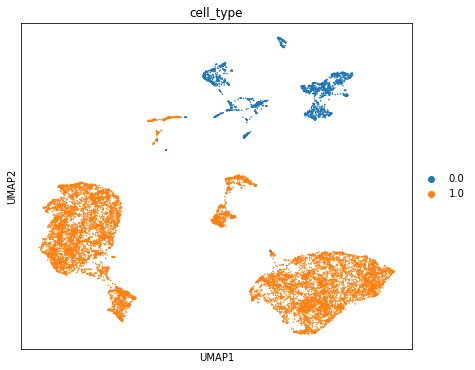

In [25]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax,save = "_mmd_scvi.png")#, show=show_plot)

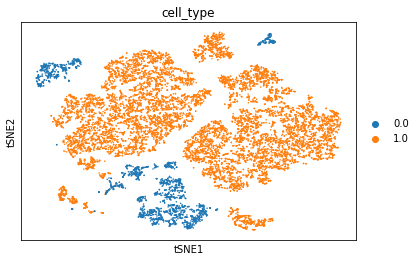

In [26]:
sc.tl.tsne(post_adata, use_rep="X_scVI")
sc.pl.tsne(post_adata,color=['cell_type'],save = "_mmd_scvi.png")#,save="_cortex_scvi.png")

In [27]:
torch.save({'model_state_dict':vae.state_dict(),'optimizer_state_dict':optimizer.state_dict()},"mmd_scvi_model.pt")


In [28]:
checkpoint = torch.load("new_mmd_scvi_model.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'new_mmd_scvi_model.pt'

In [ ]:
vae.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
from umap import UMAP

latent_u = UMAP(spread=2,random_state=7).fit_transform(latent)



from matplotlib.colors import LinearSegmentedColormap



import random

In [ ]:
cm = LinearSegmentedColormap.from_list(
        'my_cm', ['deepskyblue', 'hotpink'], N=2)
fig, ax = plt.subplots(figsize=(5, 5))
order = np.arange(latent.shape[0])
random.shuffle(order)
ax.scatter(latent_u[order, 0], latent_u[order, 1], 
           c=raw_adata.obs['Batch'][order], 
           cmap=cm, edgecolors='none', s=5)    
plt.axis("off")
fig.set_tight_layout(True)



fig
#fig.savefig("try2.png")